### SST Analysis

In [1]:
#local data paths 
riv_path = r'D:\Data\river data\USGS\top_ten.csv' 
data_dir = r'D:\NOAA Reanalysis Data\SST'
write_location= r'C:\Users\bydd1\Downloads'

In [2]:
#import packages
import pandas as pd
import vis_methods as vm 
import env_methods as em
from netCDF4 import Dataset
import os 
import time as pytime
from copy import deepcopy
import matplotlib.pyplot as plt 
import cartopy 
import cartopy.crs as ccrs
import numpy as np 

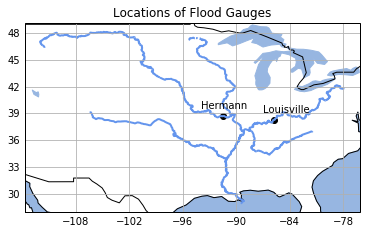

In [3]:
riv_dates = pd.read_csv(riv_path)
riv_dates = riv_dates.drop(columns = 'vicksburg')
vm.plot_poi()

In [4]:
os.chdir(data_dir)
file = os.listdir()[0]
x = Dataset(file)
lat = x['lat'][:].data.tolist()
lon = x['lon'][:].data.tolist()
time = x['time'][:].data

origin_string = x['time'].units
time = [em.convert_datetime(t, origin_string) for t in time]


In [5]:
riv_time_ind = pd.DataFrame()
for loc in riv_dates.columns.tolist():
    riv_dates[loc] = pd.to_datetime(riv_dates[loc], format = "%m/%d/%Y") #convert to dt object
    loc_ind = []
    
    for event in riv_dates[loc]:
        ind = em.find_closest_val(event, time)
        loc_ind.append(ind)
        
    riv_time_ind[loc] = loc_ind
    
riv_time_ind

,hermann,louisville
0,1675,997
1,593,1094
2,1171,362
3,1697,1322
4,1084,711
5,1073,350
6,1593,1718
7,1960,637
8,1432,1934
9,1122,951


In [6]:
bbox = {'lat' : [60, -20],
        'lon' : [360-170, 360-10]}


print(bbox)
bbox_c = {'lat': [em.find_closest_val(l, lat) for l in bbox['lat']],
         'lon': [em.find_closest_val(l, lon) for l in bbox['lon']]}
print(bbox_c)

lat = lat[bbox_c['lat'][0]:bbox_c['lat'][1]]
lon = lon[bbox_c['lon'][0]:bbox_c['lon'][1]]


{'lat': [60, -20], 'lon': [190, 350]}
{'lat': [14, 54], 'lon': [95, 175]}


In [7]:
start_time = pytime.time()
data = {}
mv = x['sst'].missing_value


d =  np.asarray(x['sst'][:, bbox_c['lat'][0]:bbox_c['lat'][1], bbox_c['lon'][0]:bbox_c['lon'][1] ])
d[d == mv] = np.nan

print(pytime.time() - start_time )

1.0044872760772705


In [8]:
anom_d = deepcopy(d)
anom_d[np.isnan(anom_d)] = 0
anom_d = em.normalize_data(anom_d, time)
anom_d[anom_d == 0] = np.nan
anom_d[anom_d == 0.0] = np.nan


C:\Users\bydd1\OneDrive\Documents\Research\Code for Babes\miss-atmo\env_methods.py:134: RuntimeWarning: invalid value encountered in true_divide
  stdev_monthly[month - 1])


In [9]:
anom_d.shape

(1994, 40, 80)

In [10]:
os.chdir(write_location)
c = ['lat', 'lon', 'stand_sst', 'sst']
    
for loc in riv_time_ind: 
    frame = {}
    for n in c: 
        frame[n] = []
    
    d_temp = np.nanmean(d[riv_time_ind[loc], :, :], axis = 0)
    anom_temp = np.nanmean(anom_d[riv_time_ind[loc], :, :], axis = 0)

    counter = 0 
    for i in range(len(lat)):
        for j in range(len(lon)):
            frame['lat'].append(lat[i])
            frame['lon'].append(lon[j])

            frame['stand_sst'].append(anom_temp[i, j])
            frame['sst'].append(d_temp[i, j])
    frame = pd.DataFrame(frame)   
    frame.fillna(-9999)
    frame.to_csv(loc + '_sst.csv')

C:\Users\bydd1\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':
C:\Users\bydd1\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


In [21]:
### testing! 

hermann = pd.read_csv('hermann_sst.csv')
louisville = pd.read_csv('louisville_sst.csv')


for f in ['h', 'l']:
    dic ={}
    if f == 'h':
        file = hermann
    if f == 'l':
        file = louisville
    for v in file: 
        if v not in ['Unnamed: 0', 'lat', 'lon']:
            array = np.zeros((len(lat), len(lon)))

            for k in range(len(file)):


                lat_ = file['lat'][k]
                lon_ = file['lon'][k]
                lat_i = lat.index(lat_)
                lon_i = lon.index(lon_)

                array[lat_i, lon_i] = file[v][k]
                array[array == -9999] = np.nan
            dic[v] = array
            
    if f == 'h': hermann_dic = deepcopy(dic)
    if f == 'l': louisville_dic = deepcopy(dic)


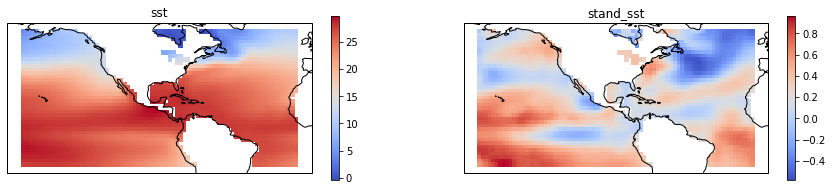

In [22]:
d = hermann_dic

plt.figure(figsize = (15, 3))
ax = plt.subplot(1, 2, 1, projection = ccrs.PlateCarree())
ax.coastlines()
mesh = plt.pcolormesh(lon, lat, d['sst'], cmap = 'coolwarm')
plt.title(v)
plt.colorbar(mesh)
ax = plt.subplot(1, 2, 2, projection = ccrs.PlateCarree())
ax.coastlines()
mesh = plt.pcolormesh(lon, lat, d['stand_sst'], cmap = 'coolwarm')
plt.title('stand_' + v)
plt.colorbar(mesh)

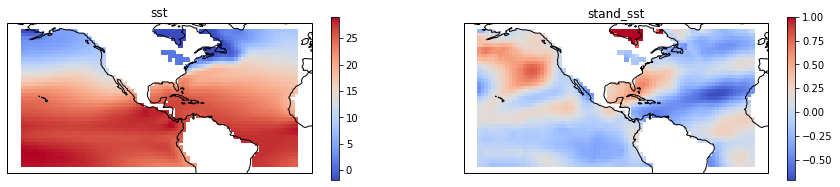

In [23]:
d = louisville_dic

plt.figure(figsize = (15, 3))
ax = plt.subplot(1, 2, 1, projection = ccrs.PlateCarree())
ax.coastlines()
mesh = plt.pcolormesh(lon, lat, d['sst'], cmap = 'coolwarm')
plt.title(v)
plt.colorbar(mesh)
ax = plt.subplot(1, 2, 2, projection = ccrs.PlateCarree())
ax.coastlines()
mesh = plt.pcolormesh(lon, lat, d['stand_sst'], cmap = 'coolwarm')
plt.title('stand_' + v)
plt.colorbar(mesh)